### Máster en Ciencia de Datos - CUNEF

### Trabajo Final de Máster

### Detección de transacciones fraudulentas con tarjetas bancarias usando técnicas de clasificación

Alba Rodríguez Berenguel

En este notebook se va a construir el modelo XGBoost 

Se van a realizar distintas pruebas para ver qué funciona mejor. Primero se realizará un modelo con el dataset completo y después con las distintas técnicas de feature selection que se han aplicado, para comprobar si se puede disminuir el número de variables y no afecta a la predicción. Después se probarán distintas técnicas para dataset desbalanceados como SMOTE, RandomUndersampler y SMOTETomek. Los pasos que se van a seguir son los siguientes:

1. Importación de librerías, funciones y datos.
2. Modelo inicial
3. Modelos con Feature Selection
4. Modelos con técnicas para dataset desbalanceados

## 1. Importación de librerías, funciones y datos

In [1]:
# Load libraries.
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, fbeta_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report
import scikitplot as skplt
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.inspection import PartialDependenceDisplay
from imblearn.combine import SMOTETomek
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function to evaluate the model.
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion Matrix: \n{}\n'.format(confusion_matrix(y_test, pred)))

In [3]:
# Load data.
X_train = pd.read_parquet("../data/processed/X_train.parquet")
y_train = pd.read_parquet("../data/processed/y_train.parquet")['isfraud']

X_test = pd.read_parquet("../data/processed/X_test.parquet")
y_test = pd.read_parquet("../data/processed/y_test.parquet")['isfraud']

X_train_boruta = pd.read_parquet("../data/processed/X_train_boruta.parquet")
X_test_boruta = pd.read_parquet("../data/processed/X_test_boruta.parquet")

X_train_rfe = pd.read_parquet("../data/processed/X_train_rfe.parquet")
X_test_rfe = pd.read_parquet("../data/processed/X_test_rfe.parquet")

X_train_lasso1 = pd.read_parquet("../data/processed/X_train_lasso1.parquet")
X_test_lasso1 = pd.read_parquet("../data/processed/X_test_lasso1.parquet")

X_train_lasso2 = pd.read_parquet("../data/processed/X_train_lasso2.parquet")
X_test_lasso2 = pd.read_parquet("../data/processed/X_test_lasso2.parquet")

In [4]:
# Import the preprocessor.
preprocessor = pickle.load(open('../models/preprocessor.pickle', 'rb'))

## 2. Modelo inicial

In [5]:
# classifier.
classifier = XGBClassifier(n_jobs = -1, random_state = 12345, scale_pos_weight=13)

xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

In [6]:
xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('catohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['productcd', 'card4',
                                                   'card6', 'm4']),
                                                 ('catbin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OrdinalEncoder())]),
                                                  ['m...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=12345, ...))])

In [7]:
# Predictions of target value for the validation set.
pred = xgb.predict(X_test)

# Predictions of probabilities of the target value for the validation set.
pred_proba = xgb.predict_proba(X_test)

evaluate_model(y_test, pred, pred_proba)

ROC-AUC score of the model: 0.936047215061448
Accuracy of the model: 0.9487544725373489

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    113837
           1       0.38      0.73      0.50      4105

    accuracy                           0.95    117942
   macro avg       0.68      0.85      0.74    117942
weighted avg       0.97      0.95      0.96    117942


Confusion Matrix: 
[[108886   4951]
 [  1093   3012]]



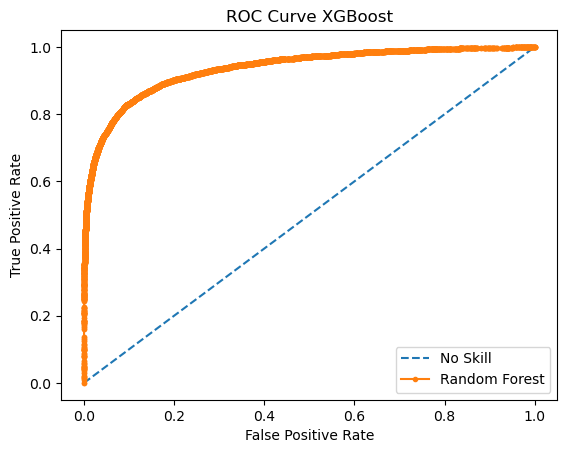

In [8]:
# Keep probabilities for the positive outcome only
yhat = pred_proba[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve XGBoost')
plt.legend()
# Show the plot
plt.show()

## 3. Modelo con Feature Selection

### 3.1. Boruta

In [9]:
# classifier.
classifier = XGBClassifier(n_jobs = -1, random_state = 12345, scale_pos_weight=13)

xgb_boruta = Pipeline([
    ('classifier', classifier)
])

In [10]:
xgb_boruta.fit(X_train_boruta, y_train)

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=12345, ...))])

In [11]:
# Predictions of target value for the validation set.
pred = xgb_boruta.predict(X_test_boruta)

# Predictions of probabilities of the target value for the validation set.
pred_proba = xgb_boruta.predict_proba(X_test_boruta)

# We evaluate the model with differents metrics with the function that we import.
evaluate_model(y_test, pred, pred_proba)

ROC-AUC score of the model: 0.9354799156864425
Accuracy of the model: 0.9489240474131353

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    113837
           1       0.38      0.73      0.50      4105

    accuracy                           0.95    117942
   macro avg       0.68      0.85      0.74    117942
weighted avg       0.97      0.95      0.96    117942


Confusion Matrix: 
[[108907   4930]
 [  1094   3011]]



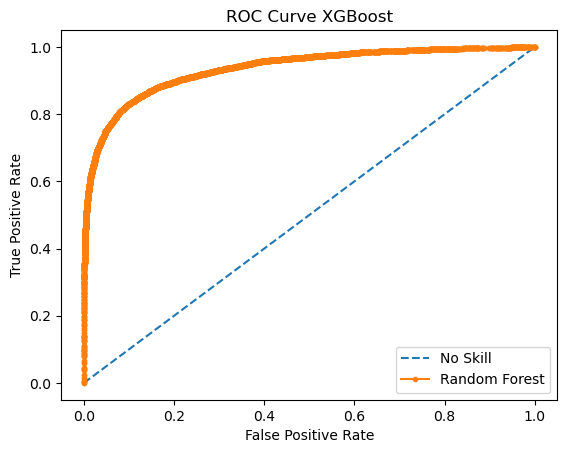

In [12]:
# Keep probabilities for the positive outcome only
yhat = pred_proba[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve XGBoost')
plt.legend()
# Show the plot
plt.show()

### 3.2. RFE

In [13]:
# classifier.
classifier = XGBClassifier(n_jobs = -1, random_state = 12345, scale_pos_weight=13)

xgb_rfe = Pipeline([
    ('classifier', classifier)
])

In [14]:
xgb_rfe.fit(X_train_rfe, y_train)

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=12345, ...))])

In [15]:
# Predictions of target value for the validation set.
pred = xgb_rfe.predict(X_test_rfe)

# Predictons of probabilities of the target value for the validation set.
pred_proba = xgb_rfe.predict_proba(X_test_rfe)

# We evaluate the model with differents metrics with the function that we import.
evaluate_model(y_test, pred, pred_proba)

ROC-AUC score of the model: 0.937273575888905
Accuracy of the model: 0.9506367536585779

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    113837
           1       0.39      0.74      0.51      4105

    accuracy                           0.95    117942
   macro avg       0.69      0.85      0.74    117942
weighted avg       0.97      0.95      0.96    117942


Confusion Matrix: 
[[109101   4736]
 [  1086   3019]]



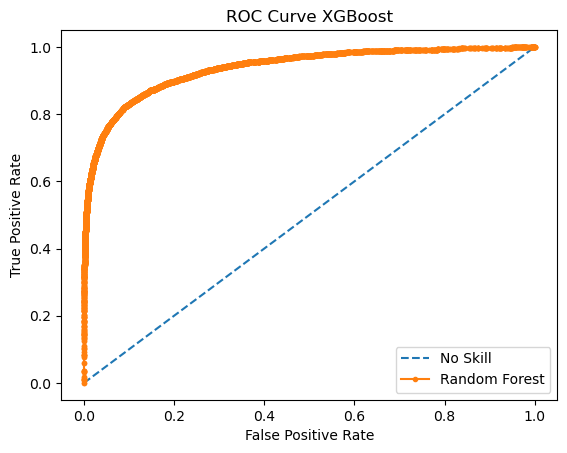

In [16]:
# Keep probabilities for the positive outcome only
yhat = pred_proba[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve XGBoost')
plt.legend()
# Show the plot
plt.show()

### 3.3. Lasso

#### Prueba 1

In [17]:
# classifier.
classifier = XGBClassifier(n_jobs = -1, random_state = 12345, scale_pos_weight=13)

xgb_lasso1 = Pipeline([
    ('classifier', classifier)
])

In [18]:
xgb_lasso1.fit(X_train_lasso1, y_train)

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=12345, ...))])

In [19]:
# Predictions of target value for the validation set.
pred = xgb_lasso1.predict(X_test_lasso1)

# Predictions of probabilities of the target value for the validation set.
pred_proba = xgb_lasso1.predict_proba(X_test_lasso1)

# We evaluate the model with differents metrics with the function that we import.
evaluate_model(y_test, pred, pred_proba)

ROC-AUC score of the model: 0.9306753442163929
Accuracy of the model: 0.940920113276017

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    113837
           1       0.34      0.72      0.46      4105

    accuracy                           0.94    117942
   macro avg       0.66      0.84      0.71    117942
weighted avg       0.97      0.94      0.95    117942


Confusion Matrix: 
[[108002   5835]
 [  1133   2972]]



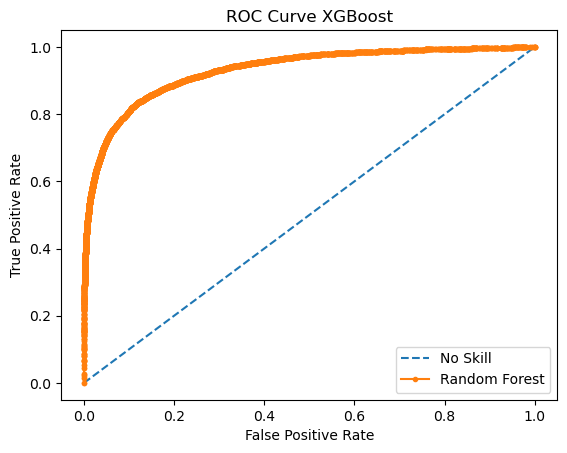

In [20]:
# Keep probabilities for the positive outcome only
yhat = pred_proba[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve XGBoost')
plt.legend()
# Show the plot
plt.show()

#### Prueba 2

In [21]:
# classifier.
classifier = XGBClassifier(n_jobs = -1, random_state = 12345, scale_pos_weight=13)

xgb_lasso2 = Pipeline([
    ('classifier', classifier)
])

In [22]:
xgb_lasso2.fit(X_train_lasso2, y_train)

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=12345, ...))])

In [23]:
# Predictions of target value for the validation set.
pred = xgb_lasso2.predict(X_test_lasso2)

# Predictions of probabilities of the target value for the validation set.
pred_proba = xgb_lasso2.predict_proba(X_test_lasso2)

# We evaluate the model with differents metrics with the function that we import.
evaluate_model(y_test, pred, pred_proba)

ROC-AUC score of the model: 0.9213263013614879
Accuracy of the model: 0.9364348578114666

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.94      0.97    113837
           1       0.32      0.71      0.44      4105

    accuracy                           0.94    117942
   macro avg       0.65      0.83      0.70    117942
weighted avg       0.97      0.94      0.95    117942


Confusion Matrix: 
[[107545   6292]
 [  1205   2900]]



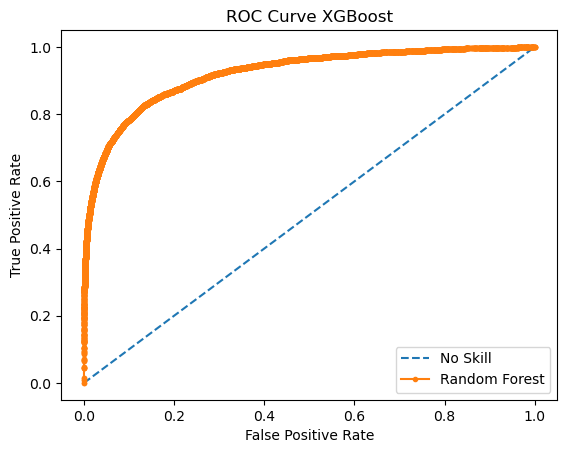

In [24]:
# Keep probabilities for the positive outcome only
yhat = pred_proba[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve XGBoost')
plt.legend()
# Show the plot
plt.show()

## 4. Modelos con técnicas para dataset desbalanceados

### 4.1. SMOTE

In [25]:
# classifier.
classifier = XGBClassifier(n_jobs = -1, random_state = 12345, scale_pos_weight=13)

xgb_smote = Pipeline([
    ('smote', SMOTE(random_state=12345, sampling_strategy=0.4)),
    ('classifier', classifier)
])

In [26]:
xgb_smote.fit(X_train_rfe, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=12345, sampling_strategy=0.4)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=12345, ...))])

In [27]:
# Predictions of target value for the validation set.
pred = xgb_smote.predict(X_test_rfe)

# Predictions of probabilities of the target value for the validation set.
pred_proba = xgb_smote.predict_proba(X_test_rfe)

evaluate_model(y_test, pred, pred_proba)

ROC-AUC score of the model: 0.9230843688643988
Accuracy of the model: 0.9239795831849553

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.93      0.96    113837
           1       0.28      0.75      0.41      4105

    accuracy                           0.92    117942
   macro avg       0.63      0.84      0.68    117942
weighted avg       0.97      0.92      0.94    117942


Confusion Matrix: 
[[105916   7921]
 [  1045   3060]]



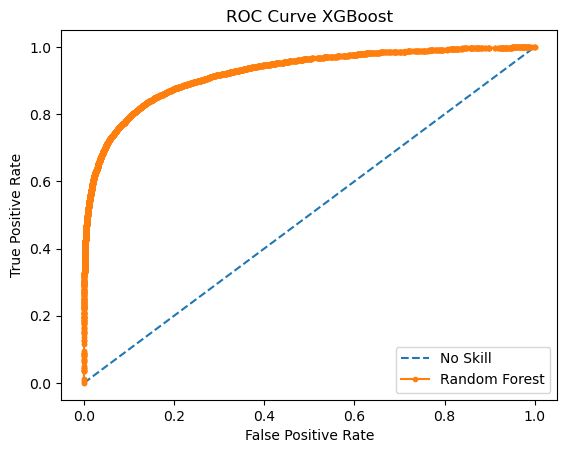

In [28]:
# Keep probabilities for the positive outcome only
yhat = pred_proba[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve XGBoost')
plt.legend()
# Show the plot
plt.show()

### 4.2. RandomUnderSampler

In [29]:
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.15)

classifier = XGBClassifier(n_jobs = -1, random_state = 12345, scale_pos_weight=6)

xgb_rus = Pipeline([
    ('smote', rus),
    ('classifier', classifier)
])

In [30]:
xgb_rus.fit(X_train_rfe, y_train)

Pipeline(steps=[('smote',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.15)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=12345, ...))])

In [31]:
# Predictions of target value for the validation set.
pred = xgb_rus.predict(X_test_rfe)

# Predictions of probabilities of the target value for the validation set.
pred_proba = xgb_rus.predict_proba(X_test_rfe)

# We evaluate the model with differents metrics with the function that we import.
evaluate_model(y_test, pred, pred_proba)

ROC-AUC score of the model: 0.9366324718173817
Accuracy of the model: 0.9067677332926354

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.91      0.95    113837
           1       0.25      0.81      0.38      4105

    accuracy                           0.91    117942
   macro avg       0.62      0.86      0.66    117942
weighted avg       0.97      0.91      0.93    117942


Confusion Matrix: 
[[103634  10203]
 [   793   3312]]



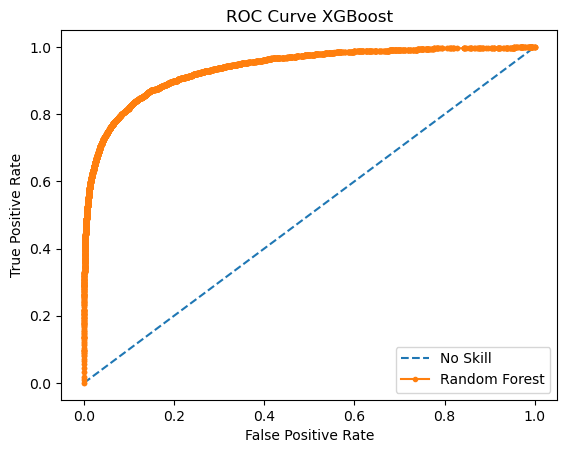

In [32]:
# Keep probabilities for the positive outcome only
yhat = pred_proba[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve XGBoost')
plt.legend()
# Show the plot
plt.show()

## SMOTETomek

In [33]:
smt = SMOTETomek(random_state=42)
classifier = XGBClassifier(n_jobs = -1, random_state = 12345, scale_pos_weight=13)

xgb_smt = Pipeline([
    ('smote', smt),
    ('classifier', classifier)
])

In [34]:
xgb_smt.fit(X_train_rfe, y_train)

Pipeline(steps=[('smote', SMOTETomek(random_state=42)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=12345, ...))])

In [35]:
# Predictions of target value for the validation set.
pred = xgb_smt.predict(X_test_rfe)

# Predictions of probabilities of the target value for the validation set.
pred_proba = xgb_smt.predict_proba(X_test_rfe)

# We evaluate the model with differents metrics with the function that we import.
evaluate_model(y_test, pred, pred_proba)

ROC-AUC score of the model: 0.9174109909935222
Accuracy of the model: 0.9101931457835207

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.92      0.95    113837
           1       0.24      0.75      0.37      4105

    accuracy                           0.91    117942
   macro avg       0.62      0.83      0.66    117942
weighted avg       0.96      0.91      0.93    117942


Confusion Matrix: 
[[104266   9571]
 [  1021   3084]]



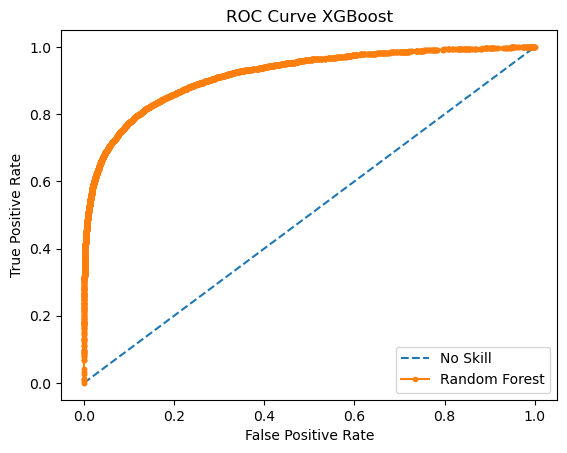

In [36]:
# Keep probabilities for the positive outcome only
yhat = pred_proba[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve XGBoost')
plt.legend()
# Show the plot
plt.show()

## 5. Exportación del mejor modelo

In [37]:
with open('../models/xgboost.pickle', 'wb') as f:
    pickle.dump(xgb_rus, f)

In [38]:
with open('../models/xgboost.pickle', 'rb') as f:
    xgb_rus = pickle.load(f)